<a href="https://colab.research.google.com/github/BMugo84/pytorch_in_25_hours/blob/main/pytorch02Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from pathlib import Path

# download helper functions from Learn Pytorch repo (if its not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


# 1. Binary classification using Scikit-Learns make_moons() function

## 1.1 create toy moons binary dataset

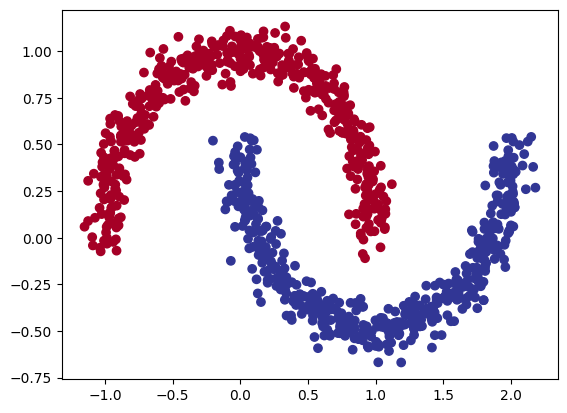

In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# make 1000 samples
n_samples = 1000

X, y = make_moons(n_samples,
                  noise=0.07,
                  random_state=42)

# visualize
plt.scatter(X[:, 0],X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
# convert data into tensors
import torch
from torch import nn
from sklearn.model_selection import train_test_split

# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# train and test splits
X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42)
X_train[:10], y_train[:10]

(tensor([[ 2.0144,  0.2466],
         [-1.0187,  0.4045],
         [-0.1252,  1.0580],
         [-0.0977,  0.9901],
         [ 0.3807, -0.2384],
         [-0.2101,  0.9271],
         [ 0.5744, -0.3417],
         [ 0.1392,  0.0353],
         [ 0.5074,  0.8867],
         [-0.9538,  0.1589]]),
 tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0.]))

## 1.2 Build a binary classification model in pytorch

In [ ]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# build a binary classification model that utilizes non-linearity
class BinaryClassificationModelV0(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initializes multiclass classification model

        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features / classes
            hidden_units (int): number of hidden units between layers, default 8
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# create an insance of the model/
model_0 = BinaryClassificationModelV0(input_features=2,
                                      output_features=1,
                                      hidden_units=16).to(device)
model_0


BinaryClassificationModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

## 1.3 Create a loss function and an optimizer

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)



In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 9.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
# accuracy function
from torchmetrics import Accuracy
acc_fn = Accuracy(task="binary")

## 1.4 Creating a training and testing loop

### 1.4.1 converting our raw logits to pred_probs to pred labels

In [ ]:
# raw data to logits
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device)).squeeze()
print("y_logits: ", y_logits[:10])

# convert our logits to pred probs
y_pred_probs = torch.sigmoid(y_logits)
print("y_pred_probs", y_pred_probs[:10])

# convert y_pred_probs to pred_labels
y_pred_labels = torch.round(y_pred_probs)
print("y_pred_labels", y_pred_labels[:10])

y_logits:  tensor([-0.1066,  0.0173, -0.0876,  0.0490, -0.0843, -0.0814, -0.0559, -0.0816,
        -0.1009,  0.0222])
y_pred_probs tensor([0.4734, 0.5043, 0.4781, 0.5123, 0.4789, 0.4797, 0.4860, 0.4796, 0.4748,
        0.5056])
y_pred_labels tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 1.])


### 1.4.2 building a training and testing loop

In [ ]:
# set the random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 1000

# put the data into a target device
X_train, y_train =  X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# for an epoch in a range:
for epoch in range(epochs):
    # in model.train
    model_0.train()
    # do the forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred_labels = torch.round(torch.sigmoid(y_logits))
    # calculate the loss
    loss = loss_fn(y_logits,
                   y_train)
    acc = acc_fn(y_pred_labels,
                 y_train.int())
    # optimizer zero grad
    optimizer.zero_grad()
    # loss backward
    loss.backward()
    # optimizer step step
    optimizer.step()
    # let's test
    # in model.eval
    model_0.eval()
    # with torch.inference_mode:
    with torch.inference_mode():
        # do the forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred_labels = torch.round(torch.sigmoid(test_logits))
        # calculate the loss
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = acc_fn(test_pred_labels,
                          y_test.int())
    # print out whats happenin
    if epoch%100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}   |   Test loss: {test_loss:.5f}, Test acc: {test_acc:2f}")

Epoch: 0, Loss: 0.71424, Acc: 0.22   |   Test loss: 0.71157, Test acc: 0.205000
Epoch: 100, Loss: 0.33466, Acc: 0.85   |   Test loss: 0.34622, Test acc: 0.820000
Epoch: 200, Loss: 0.22147, Acc: 0.89   |   Test loss: 0.21453, Test acc: 0.915000
Epoch: 300, Loss: 0.17135, Acc: 0.93   |   Test loss: 0.16118, Test acc: 0.940000
Epoch: 400, Loss: 0.11894, Acc: 0.95   |   Test loss: 0.11036, Test acc: 0.960000
Epoch: 500, Loss: 0.07416, Acc: 0.99   |   Test loss: 0.06729, Test acc: 0.985000
Epoch: 600, Loss: 0.04677, Acc: 0.99   |   Test loss: 0.04092, Test acc: 0.995000
Epoch: 700, Loss: 0.03151, Acc: 1.00   |   Test loss: 0.02656, Test acc: 1.000000
Epoch: 800, Loss: 0.02282, Acc: 1.00   |   Test loss: 0.01873, Test acc: 1.000000
Epoch: 900, Loss: 0.01750, Acc: 1.00   |   Test loss: 0.01410, Test acc: 1.000000


## 1.5 Making and evaluating predictions

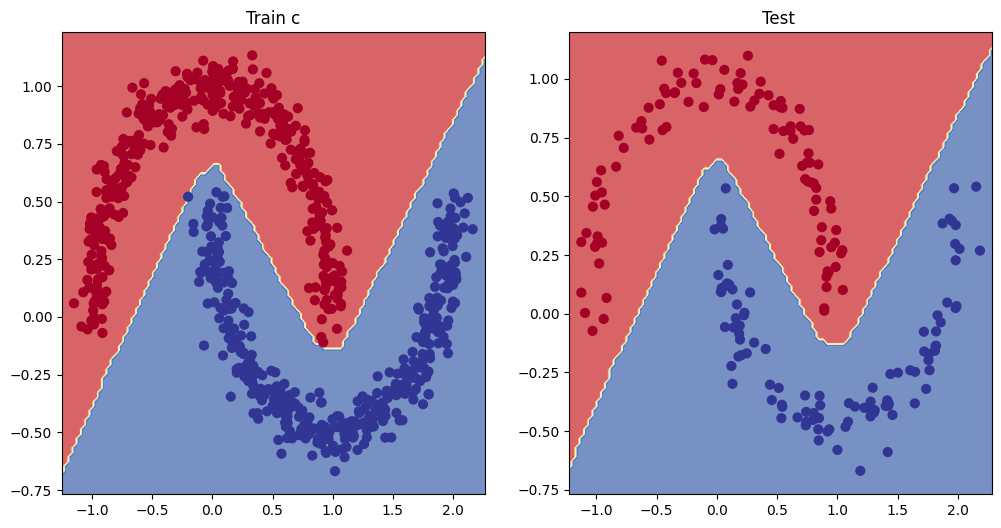

In [ ]:
# plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train c")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test ")
plot_decision_boundary(model_0, X_test, y_test)

### Tanh visualization

In [ ]:
# create adataset
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A, A.dtype

(tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]),
 torch.float32)

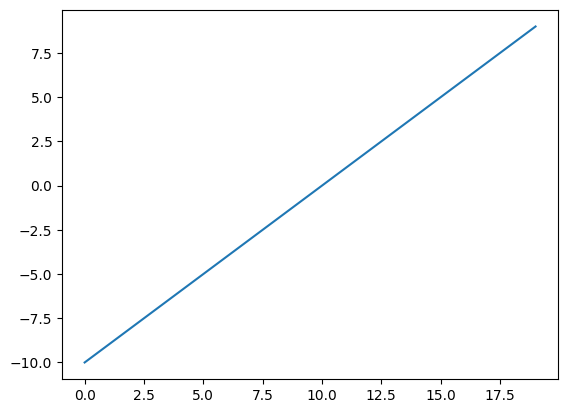

In [ ]:
# plot A
plt.plot(A)

In [ ]:
# tanh(x) = (e**x) - e(**-x) / (e**x) + e(**-x)
def tanh_made(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))
tanh_made(A)

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -0.9993, -0.9951,
        -0.9640, -0.7616,  0.0000,  0.7616,  0.9640,  0.9951,  0.9993,  0.9999,
         1.0000,  1.0000,  1.0000,  1.0000])

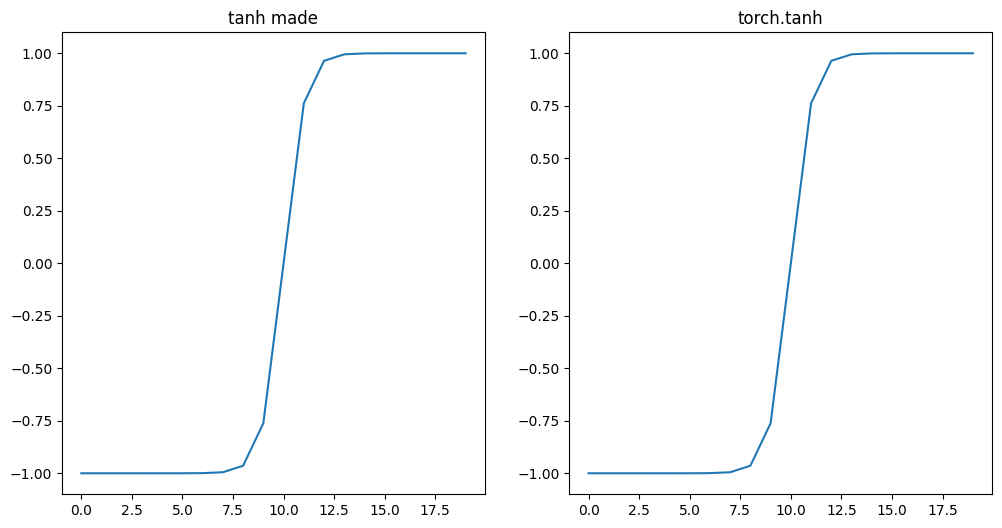

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("tanh made")
plt.plot(tanh_made(x=A))
plt.subplot(1,2,2)
plt.title("torch.tanh")
plt.plot(torch.tanh(A))

# 2. Creating a multiclass dataset using the spirals data creation function from cs231n

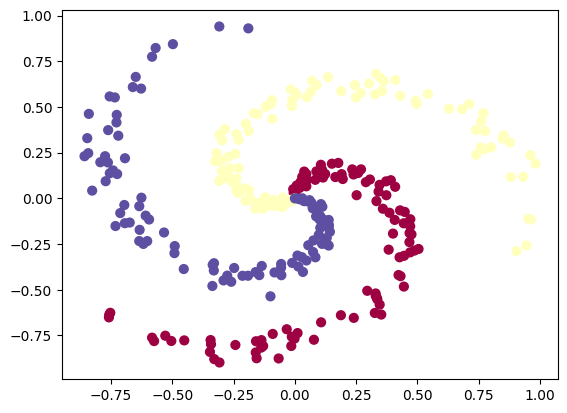

In [ ]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

### 2.1 Creating a Toy Multiclass Dataset

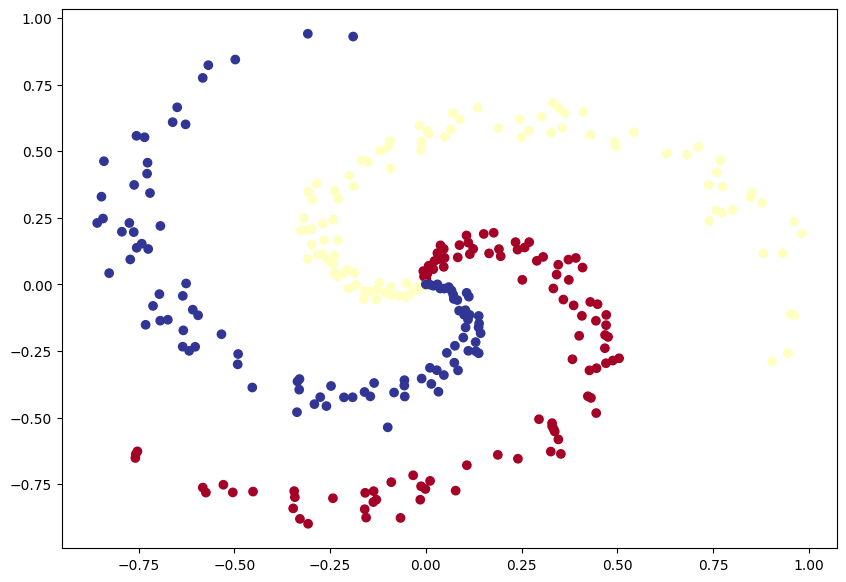

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# visualize
plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
X_train[:10], y_train[:10]

(tensor([[ 0.0286, -0.3220],
         [ 0.4231, -0.4197],
         [ 0.0194,  0.0574],
         [ 0.7757,  0.3680],
         [ 0.3626,  0.6421],
         [ 0.2898,  0.0886],
         [ 0.1954,  0.1058],
         [-0.5339, -0.1869],
         [ 0.4882, -0.2857],
         [ 0.7597,  0.4213]]),
 tensor([2, 0, 0, 1, 1, 0, 0, 2, 0, 1]))



### 2.2 Building a Multiclass Classification Model in PyTorch

In [ ]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
class SpiralModelV0(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initializes multiclass classification model

        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features / classes
            hidden_units (int): number of hidden units between layers, default 8
        """

        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# create an instance of the model
model_1 = SpiralModelV0(input_features=2,
                        output_features=3,
                        hidden_units=10).to(device)

model_1


SpiralModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [ ]:
torch.unique(y_train)

tensor([0, 1, 2])



### 2.3 Creating a Loss Function and an Optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.1)

In [ ]:
!pip install torchmetrics
# accuracy function
from torchmetrics import Accuracy
accuracy_fn = Accuracy(task="multiclass", num_classes=3)



### 2.4 Creating a Training and Testing Loop for a Multiclass PyTorch Model

In [ ]:
# output to logits to pred probs to pred labels
# output to logits
# in full
# our raw logits
model_1.eval()
with torch.inference_mode():
    y_logits = model_1(X_test.to(device))
print("# our raw logits ",y_logits[:10])

# convert our model's logit outputs to predictions probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print("convert our model's logit outputs to predictions probabilities",y_logits[:5], y_pred_probs[:5])

# Convert our prediction probs to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
print("Convert our prediction probs to prediction labels",y_preds)

# our raw logits  tensor([[-0.2214, -0.0604,  0.2366],
        [-0.2269, -0.0635,  0.2383],
        [-0.2217, -0.0519,  0.2460],
        [-0.2230, -0.0606,  0.2395],
        [-0.2151, -0.0592,  0.2264],
        [-0.2167, -0.0598,  0.2281],
        [-0.2213, -0.0612,  0.2579],
        [-0.2234, -0.0624,  0.2342],
        [-0.2229, -0.0611,  0.2377],
        [-0.2172, -0.0449,  0.2777]])
convert our model's logit outputs to predictions probabilities tensor([[-0.2214, -0.0604,  0.2366],
        [-0.2269, -0.0635,  0.2383],
        [-0.2217, -0.0519,  0.2460],
        [-0.2230, -0.0606,  0.2395],
        [-0.2151, -0.0592,  0.2264]]) tensor([[0.2663, 0.3128, 0.4210],
        [0.2653, 0.3123, 0.4224],
        [0.2644, 0.3134, 0.4222],
        [0.2656, 0.3125, 0.4219],
        [0.2685, 0.3139, 0.4176]])
Convert our prediction probs to prediction labels tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
# fit the multiclass model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
epochs = 1000

# put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# loop through data
# for an epoch in a range:
for epoch in range(epochs):
    # in model.train()
    model_1.train()
    # do the forward pass
    y_logits = model_1(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    # calculate the loss
    # print(y_logits.shape, y_blob_train.shape)
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(preds=y_pred,
                      target=y_train)
    # optimizer zero grad
    optimizer.zero_grad()
    # loss backward
    loss.backward()
    # optimizer step, step
    optimizer.step()
    # lets test!

    # in model.eval
    model_1.eval()
    # with torch inference_mode:
    with torch.inference_mode():
        # do the forward pass
        test_logits = model_1(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # calculate the loss
        # print(test_logits.shape, y_blob_test.shape)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(preds=test_preds,
                      target=y_test)
    # print out whats happenin
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0, Loss: 1.11714, Acc: 0.32% | Test loss: 1.09323, Test acc: 0.32%
Epoch: 10, Loss: 0.86766, Acc: 0.50% | Test loss: 0.85322, Test acc: 0.47%
Epoch: 20, Loss: 0.54162, Acc: 0.76% | Test loss: 0.60803, Test acc: 0.68%
Epoch: 30, Loss: 0.36698, Acc: 0.81% | Test loss: 0.41946, Test acc: 0.75%
Epoch: 40, Loss: 0.24841, Acc: 0.92% | Test loss: 0.23290, Test acc: 0.95%
Epoch: 50, Loss: 0.20032, Acc: 0.93% | Test loss: 0.19057, Test acc: 0.93%
Epoch: 60, Loss: 0.16965, Acc: 0.94% | Test loss: 0.17640, Test acc: 0.93%
Epoch: 70, Loss: 0.15962, Acc: 0.94% | Test loss: 0.16571, Test acc: 0.93%
Epoch: 80, Loss: 0.15494, Acc: 0.94% | Test loss: 0.14167, Test acc: 0.95%
Epoch: 90, Loss: 0.14496, Acc: 0.95% | Test loss: 0.13594, Test acc: 0.95%
Epoch: 100, Loss: 0.13974, Acc: 0.95% | Test loss: 0.13129, Test acc: 0.95%
Epoch: 110, Loss: 0.13511, Acc: 0.95% | Test loss: 0.12928, Test acc: 0.93%
Epoch: 120, Loss: 0.13164, Acc: 0.95% | Test loss: 0.12987, Test acc: 0.93%
Epoch: 130, Loss: 0.128



### 2.5 Making and Evaluating Predictions with a PyTorch Multiclass Model

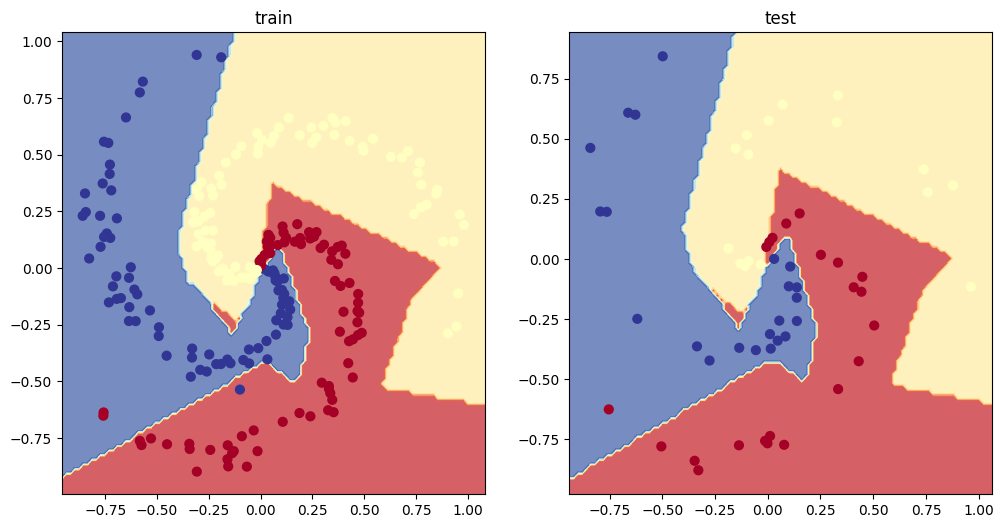

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_1, X_test, y_test)